In [106]:
import catboost
import numpy as np
import pandas as pd
from scipy.stats import randint
from imblearn.over_sampling import SMOTE
from sklearn.utils.fixes import loguniform
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

## 데이터 로드

In [2]:
train = pd.read_csv('./data/train.csv', index_col='ID')
test = pd.read_csv('./data/test.csv', index_col='ID')

In [3]:
train.shape, test.shape

((30200, 13), (12943, 12))

In [4]:
train.head()

,가입일,음성사서함이용,주간통화시간,주간통화횟수,주간통화요금,저녁통화시간,저녁통화횟수,저녁통화요금,밤통화시간,밤통화횟수,밤통화요금,상담전화건수,전화해지여부
ID,,,,,,,,,,,,,
TRAIN_00000,329,0,99.2,93,27.3,268.8,68,28.92,262.9,328,32.89,2,0
TRAIN_00001,2,80,323.9,323,83.7,269.4,326,32.09,322.8,209,32.32,2,0
TRAIN_00002,93,28,282.4,323,34.2,207.0,322,32.82,280.8,328,8.28,0,0
TRAIN_00003,223,1,221.4,223,25.1,233.0,61,23.90,203.8,234,9.36,0,0
TRAIN_00004,222,0,96.3,222,28.7,223.9,69,28.08,263.1,223,2.80,8,0


In [5]:
test.head()

,가입일,음성사서함이용,주간통화시간,주간통화횟수,주간통화요금,저녁통화시간,저녁통화횟수,저녁통화요금,밤통화시간,밤통화횟수,밤통화요금,상담전화건수
ID,,,,,,,,,,,,
TEST_00000,110,0,210.7,142,35.6,205.9,93,17.43,120.9,111,5.37,2
TEST_00001,283,1,268.5,100,30.3,283.0,92,28.32,290.0,89,8.82,0
TEST_00002,34,1,243.3,205,21.3,225.7,205,29.00,92.6,29,2.44,2
TEST_00003,209,86,83.0,93,24.1,270.6,220,22.89,266.9,81,2.80,6
TEST_00004,202,0,293.2,23,31.0,294.0,24,26.39,223.8,33,6.66,2


## 파생 변수 생성

In [6]:
train['통화시간'] = train['주간통화시간'] + train['저녁통화시간'] + train['밤통화시간']

In [7]:
train['통화횟수'] = train['주간통화횟수'] + train['저녁통화횟수'] + train['밤통화횟수']

In [8]:
train['통화요금'] = train['주간통화요금'] + train['저녁통화요금'] + train['밤통화요금']

In [9]:
test['통화시간'] = test['주간통화시간'] + test['저녁통화시간'] + test['밤통화시간']

In [10]:
test['통화횟수'] = test['주간통화횟수'] + test['저녁통화횟수'] + test['밤통화횟수']

In [11]:
test['통화요금'] = test['주간통화요금'] + test['저녁통화요금'] + test['밤통화요금']

In [12]:
train.head()

,가입일,음성사서함이용,주간통화시간,주간통화횟수,주간통화요금,저녁통화시간,저녁통화횟수,저녁통화요금,밤통화시간,밤통화횟수,밤통화요금,상담전화건수,전화해지여부,통화시간,통화횟수,통화요금
ID,,,,,,,,,,,,,,,,
TRAIN_00000,329,0,99.2,93,27.3,268.8,68,28.92,262.9,328,32.89,2,0,630.9,489,89.11
TRAIN_00001,2,80,323.9,323,83.7,269.4,326,32.09,322.8,209,32.32,2,0,916.1,858,148.11
TRAIN_00002,93,28,282.4,323,34.2,207.0,322,32.82,280.8,328,8.28,0,0,770.2,973,75.30
TRAIN_00003,223,1,221.4,223,25.1,233.0,61,23.90,203.8,234,9.36,0,0,658.2,518,58.36
TRAIN_00004,222,0,96.3,222,28.7,223.9,69,28.08,263.1,223,2.80,8,0,583.3,514,59.58


In [13]:
test.head()

,가입일,음성사서함이용,주간통화시간,주간통화횟수,주간통화요금,저녁통화시간,저녁통화횟수,저녁통화요금,밤통화시간,밤통화횟수,밤통화요금,상담전화건수,통화시간,통화횟수,통화요금
ID,,,,,,,,,,,,,,,
TEST_00000,110,0,210.7,142,35.6,205.9,93,17.43,120.9,111,5.37,2,537.5,346,58.40
TEST_00001,283,1,268.5,100,30.3,283.0,92,28.32,290.0,89,8.82,0,841.5,281,67.44
TEST_00002,34,1,243.3,205,21.3,225.7,205,29.00,92.6,29,2.44,2,561.6,439,52.74
TEST_00003,209,86,83.0,93,24.1,270.6,220,22.89,266.9,81,2.80,6,620.5,394,49.79
TEST_00004,202,0,293.2,23,31.0,294.0,24,26.39,223.8,33,6.66,2,811.0,80,64.05


## 데이터 전처리

In [14]:
label_name = '전화해지여부'

In [15]:
X1 = train.drop(columns=[label_name, '통화시간', '통화횟수', '통화요금']).copy()

In [16]:
X2 = train[['가입일', '음성사서함이용', '상담전화건수', '통화시간', '통화횟수', '통화요금']].copy()

In [17]:
y = train[label_name].copy()

In [18]:
X1.shape, X2.shape, y.shape

((30200, 12), (30200, 6), (30200,))

In [19]:
X1.head()

,가입일,음성사서함이용,주간통화시간,주간통화횟수,주간통화요금,저녁통화시간,저녁통화횟수,저녁통화요금,밤통화시간,밤통화횟수,밤통화요금,상담전화건수
ID,,,,,,,,,,,,
TRAIN_00000,329,0,99.2,93,27.3,268.8,68,28.92,262.9,328,32.89,2
TRAIN_00001,2,80,323.9,323,83.7,269.4,326,32.09,322.8,209,32.32,2
TRAIN_00002,93,28,282.4,323,34.2,207.0,322,32.82,280.8,328,8.28,0
TRAIN_00003,223,1,221.4,223,25.1,233.0,61,23.90,203.8,234,9.36,0
TRAIN_00004,222,0,96.3,222,28.7,223.9,69,28.08,263.1,223,2.80,8


In [20]:
X2.head()

,가입일,음성사서함이용,상담전화건수,통화시간,통화횟수,통화요금
ID,,,,,,
TRAIN_00000,329,0,2,630.9,489,89.11
TRAIN_00001,2,80,2,916.1,858,148.11
TRAIN_00002,93,28,0,770.2,973,75.30
TRAIN_00003,223,1,0,658.2,518,58.36
TRAIN_00004,222,0,8,583.3,514,59.58


In [21]:
y.head()

ID
TRAIN_00000    0
TRAIN_00001    0
TRAIN_00002    0
TRAIN_00003    0
TRAIN_00004    0
Name: 전화해지여부, dtype: int64

## 오버 샘플링

In [22]:
smote = SMOTE(
    random_state=42,
)

In [23]:
X1o, y1o = smote.fit_resample(X1, y)

In [24]:
X1o.shape, y1o.shape

((53764, 12), (53764,))

In [25]:
y1o.value_counts(1)

0    0.5
1    0.5
Name: 전화해지여부, dtype: float64

In [26]:
X2o, y2o = smote.fit_resample(X2, y)

In [27]:
X2o.shape, y2o.shape

((53764, 6), (53764,))

In [28]:
y1o.value_counts(1)

0    0.5
1    0.5
Name: 전화해지여부, dtype: float64

## 데이터 스플릿

In [29]:
X1_train, X1_test, y1_train, y1_test = train_test_split(
    X1o, y1o, test_size=0.1, random_state=42, stratify=y1o)

In [30]:
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2o, y2o, test_size=0.1, random_state=42, stratify=y2o)

In [208]:
model = catboost.CatBoostClassifier(
    eval_metric='TotalF1',
    random_state=42,
    logging_level='Silent',
)

In [209]:
param_grid = {
#     'n_estimators': list(range(200, 301)),
    'n_estimators': [600],
#     'learning_rate': [lr / 100 for lr in list(range(10, 60, 10))],
    'learning_rate': [0.3],
    'grow_policy': ['SymmetricTree', 'Lossguide', 'Depthwise']
}

print(param_grid)

{'n_estimators': [600], 'learning_rate': [0.3], 'grow_policy': ['SymmetricTree', 'Lossguide', 'Depthwise']}


In [ ]:
result = model.grid_search(
    param_grid=param_grid,
    X=X1_train,
    y=y1_train,
    cv=10
)
result

0:	loss: 0.9543283	best: 0.9543283 (0)	total: 3.79s	remaining: 7.59s
1:	loss: 0.9560855	best: 0.9560855 (1)	total: 12.2s	remaining: 6.08s
2:	loss: 0.9605280	best: 0.9605280 (2)	total: 19.1s	remaining: 0us
Estimating final quality...


In [182]:
model.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'TotalF1',
 'iterations': 294,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'Lossguide',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'class_names': [0, 1],
 'random_seed': 42,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'Logloss',
 'learning_rate': 0.300000011920

In [186]:
model.feature_names_

['가입일', '음성사서함이용', '상담전화건수', '통화시간', '통화횟수', '통화요금']

In [187]:
model.feature_importances_

array([20.78514684, 10.68342541, 14.58457671, 19.07789193, 20.17580803,
       14.69315107])

In [188]:
pd.DataFrame(
    model.feature_importances_, index=model.feature_names_
).sort_values(0)

,0
음성사서함이용,10.683425
상담전화건수,14.584577
통화요금,14.693151
통화시간,19.077892
통화횟수,20.175808
가입일,20.785147


In [189]:
model.save_model(
    fname='cat_model_3',
#     export_parameters=model.get_all_params()
)

In [190]:
df_result = pd.DataFrame(result)
df_result

,params,cv_results
iterations,600,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
learning_rate,0.3,NaN
grow_policy,Lossguide,NaN
test-TotalF1-mean,NaN,"[0.6505257678425725, 0.6665229077490376, 0.672..."
test-TotalF1-std,NaN,"[0.004865480519942294, 0.007117019925526583, 0..."
train-TotalF1-mean,NaN,"[0.6519394382267802, 0.6691449256367401, 0.675..."
train-TotalF1-std,NaN,"[0.004869844978021255, 0.004754321822742322, 0..."
test-Logloss-mean,NaN,"[0.6571899504434847, 0.6332777211195679, 0.614..."
test-Logloss-std,NaN,"[0.0012509025379496632, 0.002788013787660109, ..."
train-Logloss-mean,NaN,"[0.6561932154508735, 0.631601156731712, 0.6118..."


<AxesSubplot:>

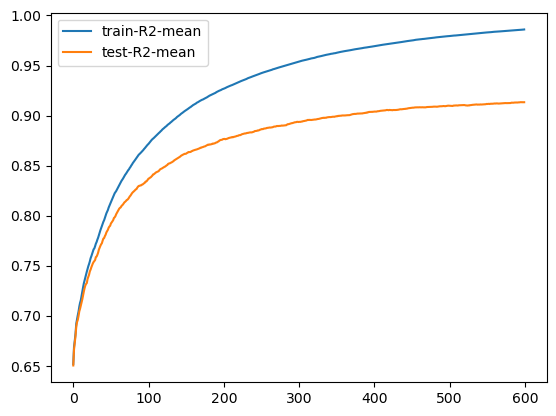

In [191]:
pd.DataFrame({
    'train-R2-mean': df_result.loc['train-TotalF1-mean', 'cv_results'],
    'test-R2-mean': df_result.loc['test-TotalF1-mean', 'cv_results']
}).plot()

In [192]:
model.fit(X2_train, y2_train)

In [196]:
y2_pred = model.predict(X2_test)

In [197]:
y1_f1_score = f1_score(y2_test, y2_pred)
y1_f1_score

0.919417296699244

In [198]:
pred = model.predict(test[['가입일', '음성사서함이용', '상담전화건수', '통화시간', '통화횟수', '통화요금']])

In [199]:
pred[:5]

array([0, 0, 0, 1, 1])

In [200]:
len(pred)

12943

In [201]:
pd.DataFrame(pred).value_counts()

0    11061
1     1882
dtype: int64

In [202]:
submission = pd.read_csv('./data/sample_submission.csv', index_col='ID')

In [203]:
submission['전화해지여부'] = pred

In [204]:
submission.head()

,전화해지여부
ID,
TEST_00000,0
TEST_00001,0
TEST_00002,0
TEST_00003,1
TEST_00004,1


In [205]:
submission.value_counts()

전화해지여부
0         11061
1          1882
dtype: int64

In [206]:
file_name = f'./submit/cat_{y1_f1_score:.5f}.csv'

In [207]:
submission.to_csv(file_name)